In [2]:
#!pip  install openpyxl

In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
from scipy.optimize import fmin
import openpyxl

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#Wczytanie danych z pliku data.xlsx
data = pd.read_excel('data.xlsx')

#Przypisanie danych z kolumn X i Y do odpowiadających im zmiennych
X_values = data['X'].values
Y_values = data['Y'].values


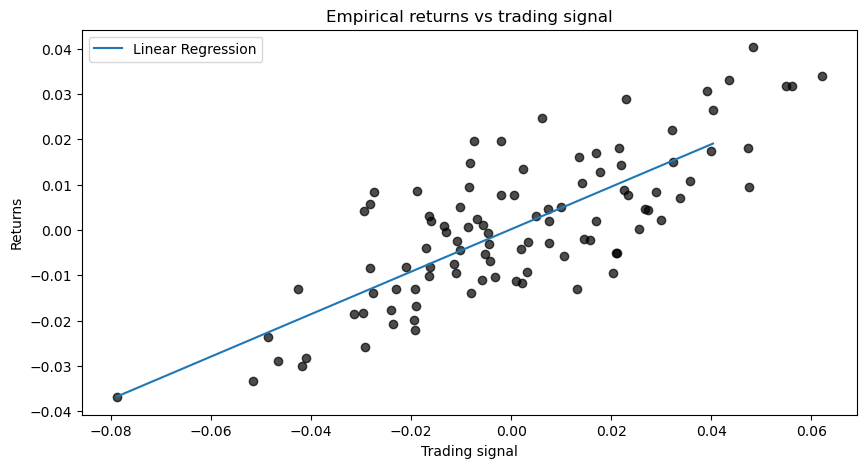

In [3]:
#Dopasowanie linii regresji do danych
slope, intercept = np.polyfit(X_values, Y_values, 1)  #1 oznacza dopasowanie linii prostej

#Stworzenie punktów do narysowania linii regresji
line_x = np.linspace(X_values.min(), Y_values.max(), 100)  #100 punktów dla gładkiej linii
line_y = slope * line_x + intercept

plt.figure(figsize=(10, 5))
plt.scatter(X_values, Y_values, color = 'black', alpha=0.7) #Dane empiryczne
plt.plot(line_x, line_y, label='Linear Regression') #Linia regresji

plt.title('Empirical returns vs trading signal')
plt.xlabel('Trading signal')
plt.ylabel('Returns')
plt.legend(loc='upper left')

plt.show()

In [4]:
#Zaktualizowana funkcja stock_loss_vect z parametrem quadratic_loss
def stock_loss_vect(factual_vect, predicted, coef=100, quadratic_loss=True):
    if quadratic_loss:
        #Inicjalizacja wektora strat
        loss_vect = np.zeros_like(factual_vect)
        #Określenie, gdzie wyniki faktyczne i przewidywane są przeciwne (tj. mają różne znaki)
        ix_vect = factual_vect * predicted < 0
        #Zastosowanie kwadratowej funkcji straty w przypadku sprzecznych wyników
        loss_vect[ix_vect] = coef * predicted ** 2 + abs(factual_vect[ix_vect] - predicted)
        #Zastosowanie absolutnej straty w przypadku zgodnych wyników
        loss_vect[~ix_vect] = abs(factual_vect[~ix_vect] - predicted)
    else:
        #Gdy quadratic_loss jest False, po prostu liczymy absolutną różnicę
        loss_vect = abs(factual_vect - predicted)

    #Zwracamy średnią wartość straty
    return loss_vect.mean()

In [ ]:
def BayesActionPrediction(X, Y, coef = 100, quadratic_loss = True):
    #Definicja modelu w PyMC (model bayesowski)
    with pm.Model() as model:
        #Priorytet rozkładu dla odchylenia standardowego (std)
        std = pm.Uniform("std", 0, 100)
        
        #Priorytet rozkładu normalnego dla współczynnika regresji beta i stałej alpha
        beta = pm.Normal("beta", mu=0, sigma=100)
        alpha = pm.Normal("alpha", mu=0, sigma=100)
        
        #Definicja średniej (mean) jako funkcji X, alfa i beta (model liniowy)
        mean = pm.Deterministic("mean", alpha + beta * X)
        
        #Model obserwacji, zakładając, że zmienne Y są rozkładem normalnym z określoną średnią i odchyleniem standardowym
        obs = pm.Normal("obs", mu=mean, sigma=std, observed=Y)

        #Próbkowanie z rozkładu a posteriori przy użyciu MCMC (Markov Chain Monte Carlo)
        idata = pm.sample(2000, tune=1000, return_inferencedata=True)
    
    #Wyciąganie próbek dla std (odchylenie standardowe), alpha (stała) i beta (współczynnik regresji)
    std_samples = idata.posterior["std"].values.flatten()
    alpha_samples = idata.posterior["alpha"].values.flatten()
    beta_samples = idata.posterior["beta"].values.flatten()

    #Ustawienia dla predykcji optymalnych (zakładając 50 punktów do obliczeń)
    N = len(std_samples)  # liczba próbek
    noise = std_samples * np.random.randn(N)  # generowanie szumu na podstawie próbek std
    opt_predictions = np.zeros(50)  # wektor na optymalne predykcje
    trade_signals = np.linspace(X.min(), X.max(), 50)  # generowanie punktów sygnałów handlowych w zadanym zakresie

    #Obliczanie optymalnych predykcji
    for i, signal in enumerate(trade_signals):
        #Dla każdego sygnału handlowego obliczamy możliwe wyniki na podstawie próbek alpha, beta i szumu
        possible_outcomes = alpha_samples + beta_samples * signal + noise
        
        #Funkcja minimalizacji - wylicza stratę (loss) dla podanej predykcji
        def tomin(pred):
            return stock_loss_vect(possible_outcomes, pred, coef, quadratic_loss)
        
        #Minimalizujemy stratę dla każdego sygnału handlowego
        opt_predictions[i] = fmin(tomin, 0, disp=False)

    #Zwracamy wyniki: sygnały handlowe i odpowiadające im optymalne predykcje zwrotów
    return trade_signals, opt_predictions

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, beta, alpha]


d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 273 seconds.
C:\Users\My\AppData\Local\Temp\ipykernel_9008\1968592029.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  opt_predictions[i] = fmin(tomin, 0, disp=False)


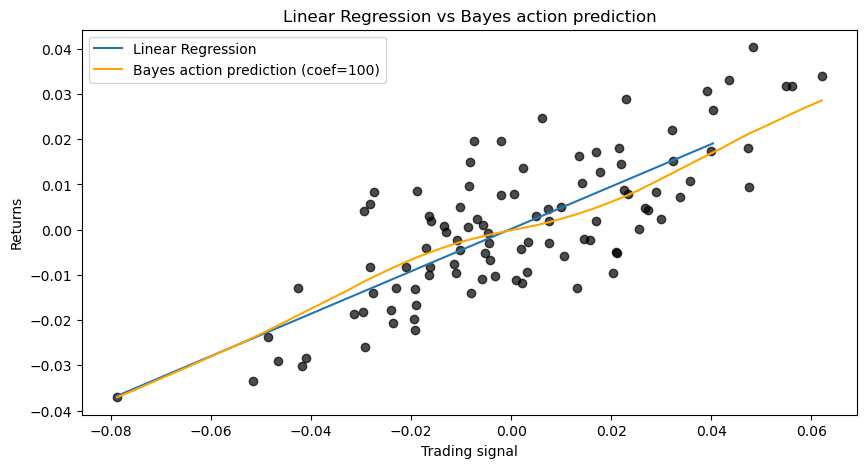

In [6]:
coef = 100
trade_signals_100, opt_predictions_100 = BayesActionPrediction(X = X_values, Y = Y_values, coef = coef, quadratic_loss = True)
plt.figure(figsize=(10, 5))
plt.scatter(X_values, Y_values, color = 'black', alpha=0.7) #Dane empiryczne
plt.plot(line_x, line_y, label='Linear Regression') #Linia regresji
#Dodanie krzywej predykcji dla Bayesowskiego modelu i regresji
plt.plot(trade_signals_100, opt_predictions_100, color='orange', label=f'Bayes action prediction (coef={coef})')

plt.title('Linear Regression vs Bayes action prediction')
plt.xlabel('Trading signal') #Sygnały handlowe - wskazują czy warto kupować
plt.ylabel('Returns') #Przewidywane zwroty z zakupów
plt.legend(loc='upper left')

plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, beta, alpha]


d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 258 seconds.
C:\Users\My\AppData\Local\Temp\ipykernel_9008\1968592029.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  opt_predictions[i] = fmin(tomin, 0, disp=False)


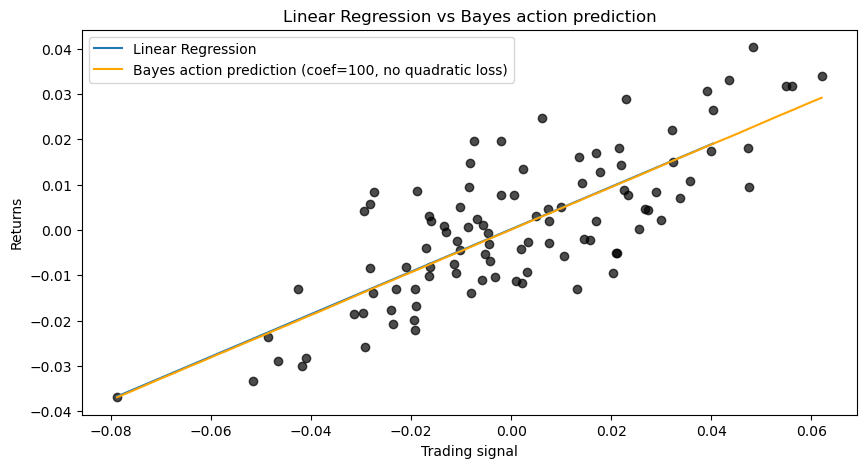

In [7]:
coef = 100
trade_signals_no_ql, opt_predictions_no_ql = BayesActionPrediction(X = X_values, Y = Y_values, coef = coef, quadratic_loss = False)
plt.figure(figsize=(10, 5))
plt.scatter(X_values, Y_values, color = 'black', alpha=0.7) #Dane empiryczne
plt.plot(line_x, line_y, label='Linear Regression') #Linia regresji
#Dodanie krzywej predykcji dla Bayesowskiego modelu i regresji
plt.plot(trade_signals_no_ql, opt_predictions_no_ql, color='orange', label=f'Bayes action prediction (coef={coef}, no quadratic loss)')

plt.title('Linear Regression vs Bayes action prediction')
plt.xlabel('Trading signal') #Sygnały handlowe - wskazują czy warto kupować
plt.ylabel('Returns') #Przewidywane zwroty z zakupów
plt.legend(loc='upper left')

plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, beta, alpha]


d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 276 seconds.
C:\Users\My\AppData\Local\Temp\ipykernel_9008\1968592029.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  opt_predictions[i] = fmin(tomin, 0, disp=False)


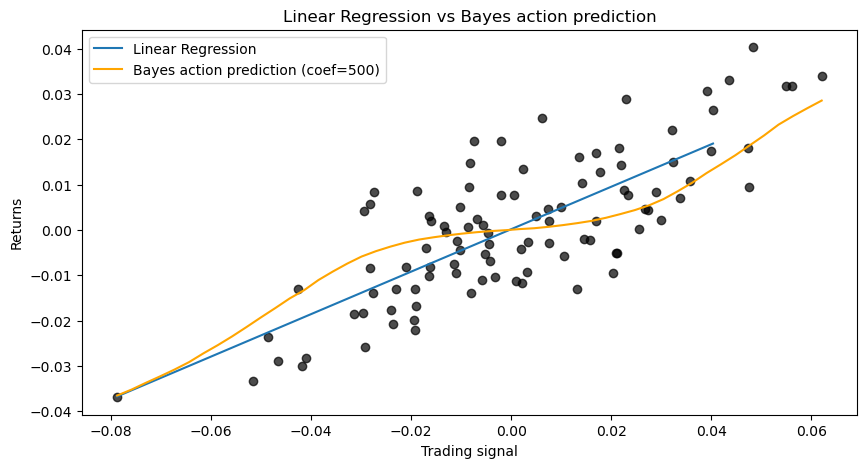

In [8]:
coef = 500
trade_signals_500, opt_predictions_500 = BayesActionPrediction(X = X_values, Y = Y_values, coef = coef, quadratic_loss = True)
plt.figure(figsize=(10, 5))
plt.scatter(X_values, Y_values, color = 'black', alpha=0.7) #Dane empiryczne
plt.plot(line_x, line_y, label='Linear Regression') #Linia regresji
#Dodanie krzywej predykcji dla Bayesowskiego modelu i regresji
plt.plot(trade_signals_500, opt_predictions_500, color='orange', label=f'Bayes action prediction (coef={coef})')

plt.title('Linear Regression vs Bayes action prediction')
plt.xlabel('Trading signal') #Sygnały handlowe - wskazują czy warto kupować
plt.ylabel('Returns') #Przewidywane zwroty z zakupów
plt.legend(loc='upper left')

plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, beta, alpha]


d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 258 seconds.
C:\Users\My\AppData\Local\Temp\ipykernel_9008\1968592029.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  opt_predictions[i] = fmin(tomin, 0, disp=False)


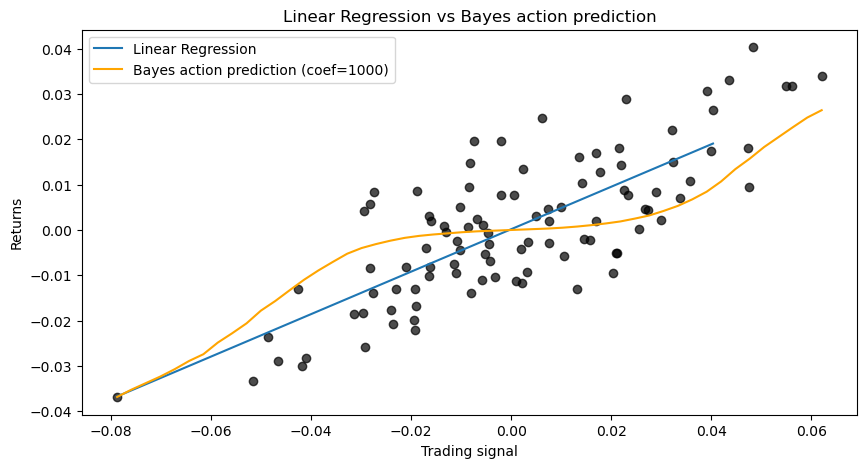

In [9]:
coef = 1000
trade_signals_1000, opt_predictions_1000 = BayesActionPrediction(X = X_values, Y = Y_values, coef = coef, quadratic_loss = True)
plt.figure(figsize=(10, 5))
plt.scatter(X_values, Y_values, color = 'black', alpha=0.7) #Dane empiryczne
plt.plot(line_x, line_y, label='Linear Regression') #Linia regresji
#Dodanie krzywej predykcji dla Bayesowskiego modelu i regresji
plt.plot(trade_signals_1000, opt_predictions_1000, color='orange', label=f'Bayes action prediction (coef={coef})')

plt.title('Linear Regression vs Bayes action prediction')
plt.xlabel('Trading signal') #Sygnały handlowe - wskazują czy warto kupować
plt.ylabel('Returns') #Przewidywane zwroty z zakupów
plt.legend(loc='upper left')

plt.show()

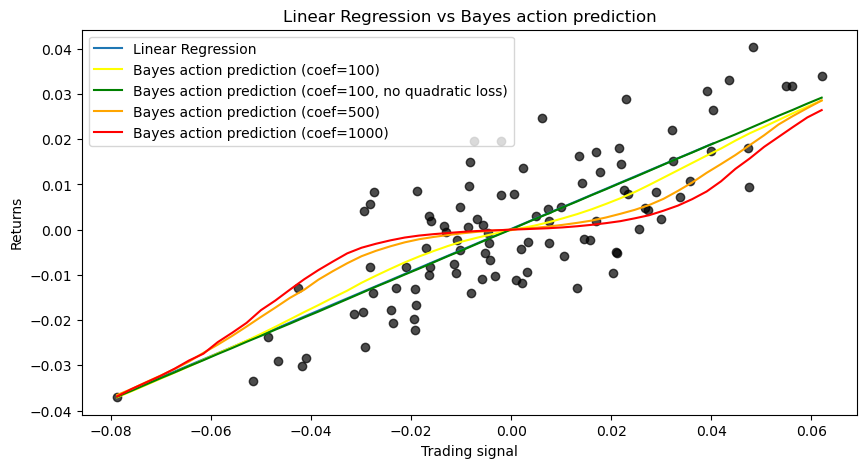

In [10]:
plt.figure(figsize=(10, 5))
plt.scatter(X_values, Y_values, color = 'black', alpha=0.7) #Dane empiryczne
plt.plot(line_x, line_y, label='Linear Regression') #Linia regresji
#Dodanie krzywej predykcji dla Bayesowskiego modelu i regresji
plt.plot(trade_signals_100, opt_predictions_100, color='yellow', label=f'Bayes action prediction (coef=100)')
plt.plot(trade_signals_no_ql, opt_predictions_no_ql, color='green', label=f'Bayes action prediction (coef=100, no quadratic loss)')
plt.plot(trade_signals_500, opt_predictions_500, color='orange', label=f'Bayes action prediction (coef=500)')
plt.plot(trade_signals_1000, opt_predictions_1000, color='red', label=f'Bayes action prediction (coef=1000)')

plt.title('Linear Regression vs Bayes action prediction')
plt.xlabel('Trading signal') #Sygnały handlowe - wskazują czy warto kupować
plt.ylabel('Returns') #Przewidywane zwroty z zakupów
plt.legend(loc='upper left')

plt.show()

Coef (coefficient - współczynnik przy części kwadratowej funkcji strat) jest hiperparametrem, który modyfikuje charakter funkcji straty, a przez to wpływa na zachowanie modelu.


Większe współczynnik: Bardziej konserwatywne przewidywania (model minimalizuje ryzyko dużych błędów, jest bardziej ostrożnych w swoich przewidywaniach).


Mniejsze współczynnik: Bardziej agresywne przewidywania (model pozwala na większe odchylenia w optymalizacji, jest mniej ostrożnych w swoich przewidywaniach).


Wraz ze wzrostem wartości coef model postepuje bardziej zachowawczo